In [1]:
# Notebook to browse through the dataset and explore
# conda environment: curate_data

In [1]:
import pandas as pd
from functions import get_data, merge_data
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
import csv

In [2]:
normalized_data = "/mnt/container-nle-microbiome/datav3/joint/abundance/"

In [3]:
def make_barplot(data, column, title, order=None):
    ax = sns.countplot(data=data, 
                    x=column, 
                    hue=column,
                    order=order)

    for i in ax.containers:
        ax.bar_label(i,)

    ax.set_title(title)

In [4]:
# get metadata for individual studies of the current batch 
# (all datasets that are currently available in '../data/normalized')
metadata = get_data(normalized_data, sep=",")

# merge metadata of all studies into one dataframe
merged_metadata = merge_data(metadata, 'fieldname')

# drop fieldname column in individual datasets after use
for study_name in metadata:
    metadata[study_name].drop(columns=['fieldname'], inplace=True)

# create transposed version of merged metadata
merged_T = merged_metadata.T
merged_T.fillna('nd', inplace=True)

In [5]:
# import the IDs of the potentially duplicated samples
duplicates_path = f"{normalized_data}duplicates/"

def get_duplicates(identifier):
    with open(f"{duplicates_path}{identifier}_IDs.txt", "r") as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter="\t")
        for line in tsv_reader:
            return line
        
abundance_duplicates = get_duplicates("abundance")
presence_duplicates = get_duplicates("presence")

# Exploratory Plots

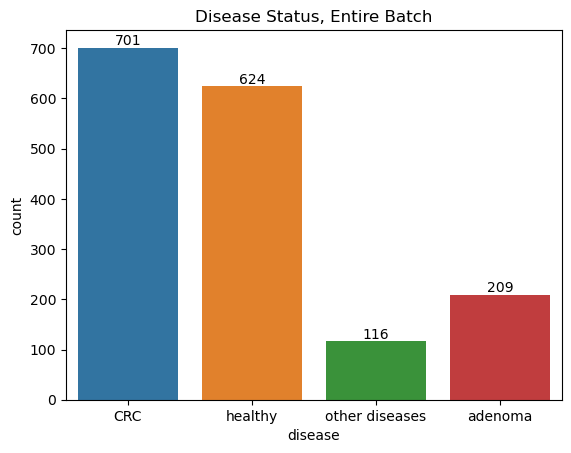

In [6]:
# plot ratio between health, diseased and adenoma subjects
sub_diseases = merged_T[['disease', 'gender', 'country']].copy()
sub_diseases.loc[sub_diseases['disease'].str.contains('CRC'), 'disease'] = "CRC"
sub_diseases.loc[sub_diseases['disease'].str.contains('adenoma'), 'disease'] = "adenoma"
sub_diseases.loc[(sub_diseases['disease'] != 'CRC') & 
        (sub_diseases['disease'] != 'adenoma') & 
        (sub_diseases['disease'] != 'healthy'), 'disease'] = "other diseases"

title = "Disease Status, Entire Batch"
make_barplot(sub_diseases, 'disease', title)


/tmp/ipykernel_954747/2198392964.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


[Text(0, 0.0, '0'),
 Text(0, 0.2, '20'),
 Text(0, 0.4, '40'),
 Text(0, 0.6000000000000001, '60'),
 Text(0, 0.8, '80'),
 Text(0, 1.0, '100'),
 Text(0, 1.2000000000000002, '120')]

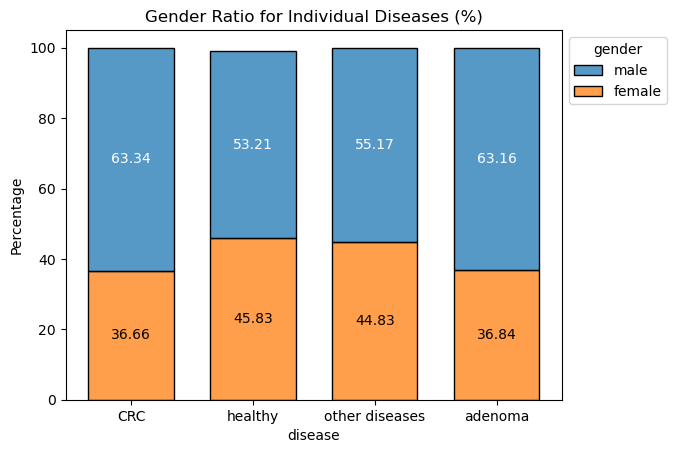

In [7]:
# stacked barplot for gender ratio in each disease group
# create input data
sub_disease_gender  = dict()
for disease in sub_diseases['disease'].unique():
    total = len(sub_diseases.loc[sub_diseases['disease'] == disease]) 
    gender = sub_diseases.loc[sub_diseases['disease'] == disease, 'gender'].value_counts()
    male = gender.loc['male']
    female = gender.loc['female']
    perc_m = male / total
    perc_f = female / total
    sub_disease_gender[disease] = {'total': total,
                                   'male': male,
                                   'female': female,
                                   'perc_m':perc_m,
                                   'perc_f':perc_f}
    

gender = list()
for i in range(len(sub_disease_gender.keys())):
    gender.extend(['male', 'female'])

disease = list()
for key in sub_disease_gender.keys():
    disease.extend(2*[key])

percentage = list()
for key in sub_disease_gender:
    percentage.append(sub_disease_gender[key]['perc_m'])
    percentage.append(sub_disease_gender[key]['perc_f'])


stacked_df = pd.DataFrame({
    'gender': gender,
    'disease': disease,
    'percentage': percentage
}
)


labels_m = stacked_df.loc[::2, 'percentage'].tolist()
labels_m = [round(label*100, 2) for label in labels_m]



labels_f = stacked_df.loc[1::2, 'percentage'].tolist()
labels_f = [round(label*100, 2) for label in labels_f]


ax = sns.histplot(stacked_df, x='disease', 
             hue='gender', 
             multiple='stack', 
             shrink=0.7,
             weights='percentage')

ax.set_ylabel('Percentage')
ax.set_title('Gender Ratio for Individual Diseases (%)')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1,1))

ax.bar_label(ax.containers[0], labels=labels_f, label_type='center')
ax.bar_label(ax.containers[1], labels=labels_m,label_type='center', color='white')

yticks = [str(int(y*100)) for y in ax.get_yticks()]
ax.set_yticklabels(yticks)


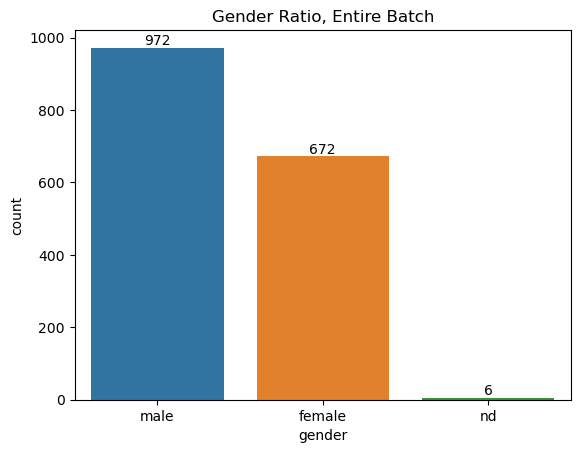

In [8]:
# plot gender ratio
title = "Gender Ratio, Entire Batch"
make_barplot(merged_T, 'gender', title)

Text(0.5, 1.0, 'Age Distribution, Entire Batch (Excluding samples without annotation!)')

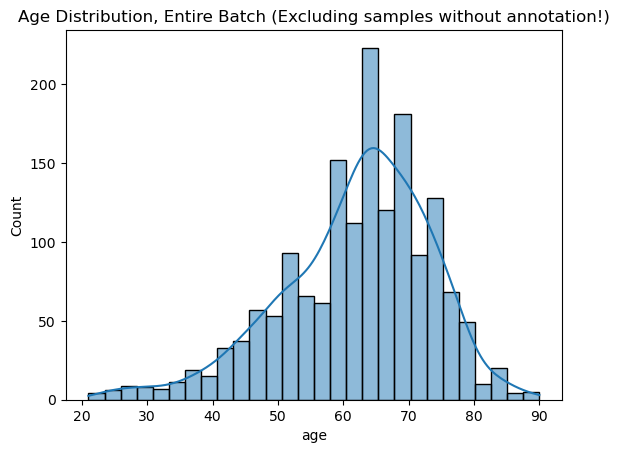

In [9]:
# plot age distribution
sub = merged_T.loc[merged_T['age'] != 'nd', ['age', 'disease']]

title = "Age Distribution, Entire Batch (Excluding samples without annotation!)"


ax = sns.histplot(data=sub['age'].to_frame().astype(int), 
                  x='age',
                  kde=True)

ax.set_title(title)

/tmp/ipykernel_954747/3214877872.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=sub.loc[sub['disease'].str.contains('CRC'), 'age'].astype(int),
/tmp/ipykernel_954747/3214877872.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=sub.loc[sub['disease'].str.contains('healthy'), 'age'].astype(int),


Text(0.5, 1.0, 'Age Distributions for CRC patients and healthy subjects')

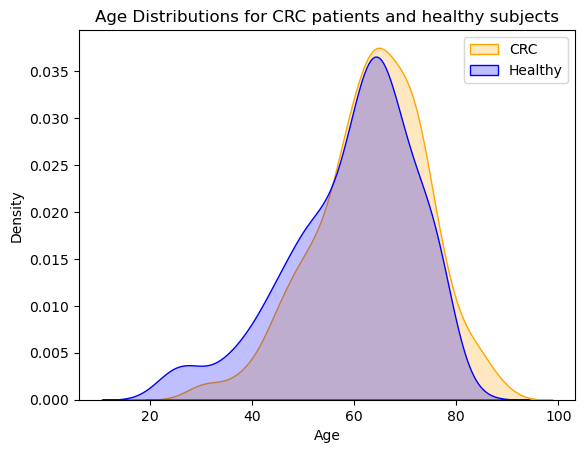

In [10]:
sns.kdeplot(data=sub.loc[sub['disease'].str.contains('CRC'), 'age'].astype(int), 
            color='orange',
            shade=True,
            label='CRC')

sns.kdeplot(data=sub.loc[sub['disease'].str.contains('healthy'), 'age'].astype(int), 
            color='blue',
            shade=True,
            label="Healthy")

plt.legend()
plt.xlabel("Age")
plt.title("Age Distributions for CRC patients and healthy subjects")

In [22]:
print(f"Minimum Age: {str(min(sub['age'].astype(int).tolist()))}")
print(f"Maximum Age: {str(max(sub['age'].astype(int).tolist()))}")
print(f"Mean Age: {str(round(sub['age'].astype(int).mean()))}")
print(f"Median Age: {str(round(sub['age'].astype(int).median()))}")

Minimum Age: 21
Maximum Age: 90
Mean Age: 62
Median Age: 64


Text(0.5, 1.0, 'BMI Distribution, Entire Batch')

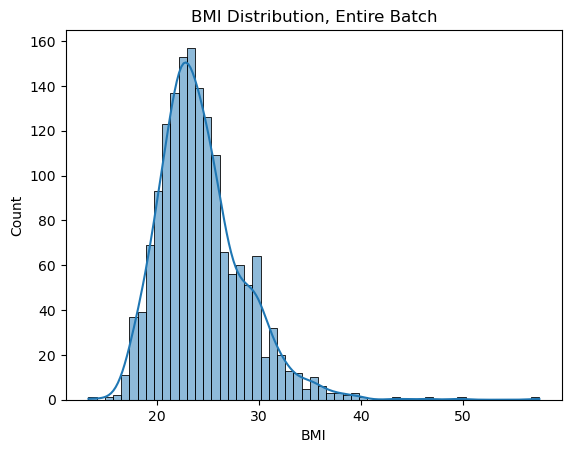

In [23]:
# plot age distribution
sub = merged_T.loc[merged_T['BMI'] != 'nd', ['BMI', 'disease']]

title = "BMI Distribution, Entire Batch"

ax = sns.histplot(data=sub['BMI'].to_frame().astype(float), 
                  x='BMI',
                  kde=True)
ax.set_title(title)

/tmp/ipykernel_954747/4068971665.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=sub.loc[sub['disease'].str.contains('CRC'), 'BMI'].astype(float),
/tmp/ipykernel_954747/4068971665.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=sub.loc[sub['disease'].str.contains('healthy'), 'BMI'].astype(float),


Text(0.5, 1.0, 'BMI Distributions for CRC patients and healthy subjects')

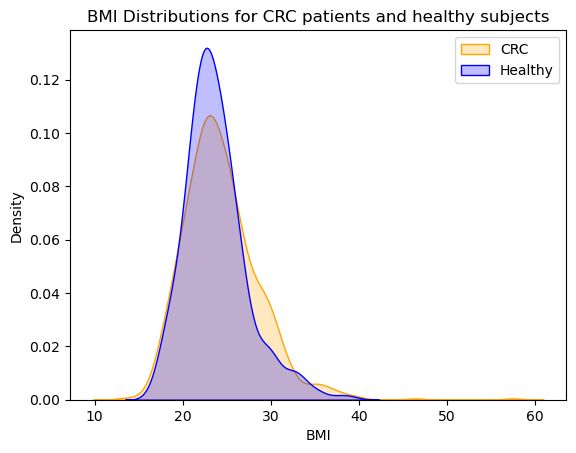

In [24]:
sns.kdeplot(data=sub.loc[sub['disease'].str.contains('CRC'), 'BMI'].astype(float), 
            color='orange',
            shade=True,
            label='CRC')

sns.kdeplot(data=sub.loc[sub['disease'].str.contains('healthy'), 'BMI'].astype(float), 
            color='blue',
            shade=True,
            label="Healthy")

plt.legend()
plt.xlabel("BMI")
plt.title("BMI Distributions for CRC patients and healthy subjects")

In [27]:
print(f"Minimum BMI: {str(min(sub['BMI'].astype(float).tolist()))}")
print(f"Maximum BMI: {str(max(sub['BMI'].astype(float).tolist()))}")
print(f"Mean BMI: {str(round(sub['BMI'].astype(float).mean()))}")
print(f"Median BMI: {str(round(sub['BMI'].astype(float).median()))}")

Minimum BMI: 13.3
Maximum BMI: 57.46349
Mean BMI: 24
Median BMI: 24


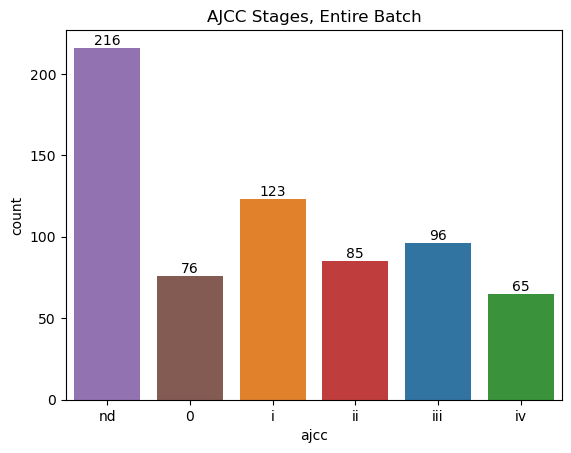

In [39]:
# plot regarding TNM/AJCC staging

title = "AJCC Stages, Entire Batch"
order = ['nd', '0', 'i', 'ii', 'iii', 'iv']
make_barplot(merged_T.loc[merged_T['disease'].str.contains('CRC')], 'ajcc', title, order=order)

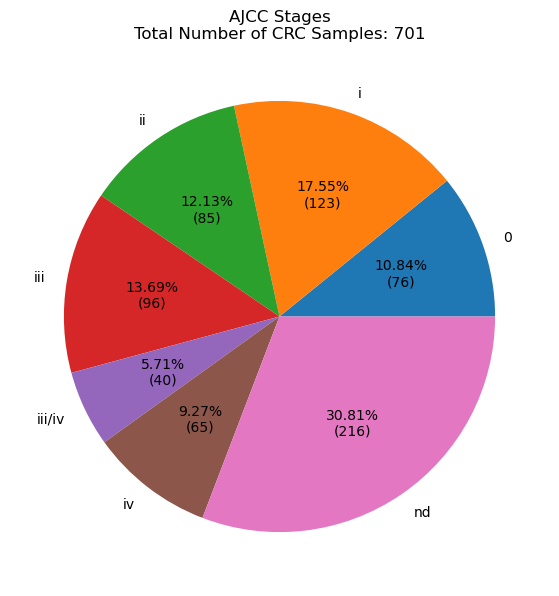

In [41]:
# ajcc staging pie chart

sub = merged_T.loc[merged_T['disease'].str.contains('CRC')]

counts = sub['ajcc'].value_counts()

labels = counts.index.tolist()
data = counts.values.tolist()

data_dict = dict(zip(labels, data))
data_dict_ordered = OrderedDict(sorted(data_dict.items()))

fig = plt.figure(figsize=(10, 7))\

def create_label(x):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

total = len(sub)

plt.pie(data_dict_ordered.values(), labels=data_dict_ordered.keys(), autopct=create_label)
plt.title(f"AJCC Stages\nTotal Number of CRC Samples: {str(len(sub))}")

plt.show()


In [43]:
# create a pie chart with information about how many samples contain ajcc stage, tnm stage, both or none
merged_T.loc[(merged_T['ajcc'] == 'nd') & (merged_T['tnm'] == 'nd'), 'stage_info'] = str('none')
merged_T.loc[(merged_T['ajcc'] != 'nd') & (merged_T['tnm'] == 'nd'), 'stage_info'] = 'ajcc_only'
merged_T.loc[(merged_T['ajcc'] == 'nd') & (merged_T['tnm'] != 'nd'), 'stage_info'] = 'tnm_only'
merged_T.loc[(merged_T['ajcc'] != 'nd') & (merged_T['tnm'] != 'nd'), 'stage_info'] = 'both'

merged_T.loc[merged_T['disease'].str.contains('CRC'), 'stage_info'].value_counts()

/tmp/ipykernel_3984059/1769469942.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'none' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_T.loc[(merged_T['ajcc'] == 'nd') & (merged_T['tnm'] == 'nd'), 'stage_info'] = str('none')


stage_info
ajcc_only    298
both         187
none         141
tnm_only      75
Name: count, dtype: int64

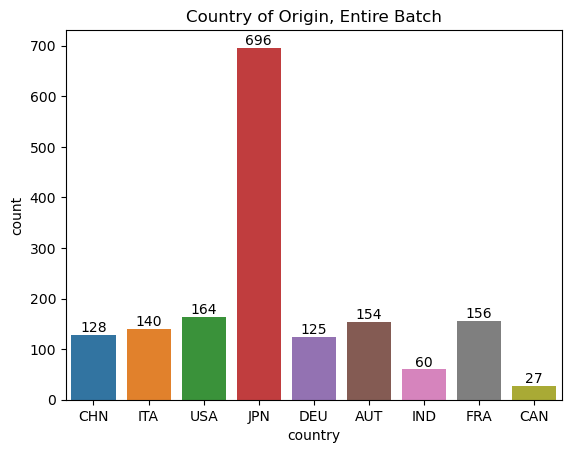

In [44]:
# plot to show country of origin
sub = merged_metadata.loc['country'].to_frame()
title = "Country of Origin, Entire Batch"
make_barplot(merged_T, 'country', title)

[Text(0, 0, '128'),
 Text(0, 0, '140'),
 Text(0, 0, '164'),
 Text(0, 0, '696'),
 Text(0, 0, '125'),
 Text(0, 0, '154'),
 Text(0, 0, '60'),
 Text(0, 0, '156'),
 Text(0, 0, '27')]

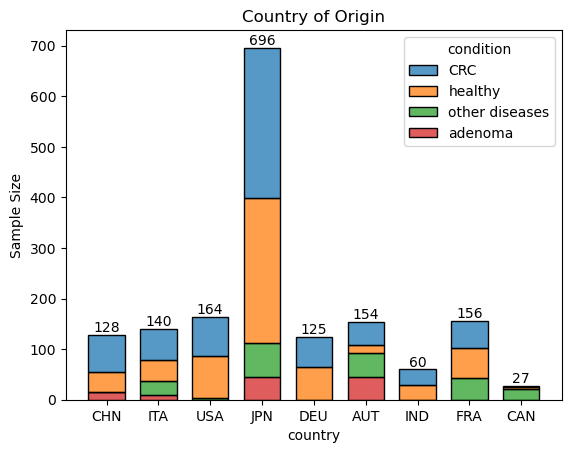

In [45]:
sub_country_disease = dict()
for country in sub_diseases['country'].unique():
    total = len(sub_diseases.loc[sub_diseases['country'] == country])
    disease = sub_diseases.loc[sub_diseases['country'] == country, 'disease'].value_counts()
    crc = disease.loc['CRC']
    control = disease.loc['healthy']
    try:
        other = disease.loc['other diseases']
    except KeyError:
        other = 0
    try:
        adenoma = disease.loc['adenoma']
    except KeyError:
        adenoma = 0
    sub_country_disease[country] = {'total':total,
                                    'CRC': crc, 
                                    'CRC_p': crc/total,
                                    'healthy': control, 
                                    'healthy_p': control/total,
                                    'adenoma': adenoma,  
                                    'adenoma_p': adenoma/total,
                                    'other': other, 
                                    'other_p': other/total,
                                   }

condition = list()
for i in range(len(sub_country_disease.keys())):
    condition.extend(sub_diseases['disease'].unique().tolist())

country_list = list()
for key in sub_country_disease.keys():
    country_list.extend(len(sub_diseases['disease'].unique())*[key])


disease_count = list()
percentage = list()
totals = list()
for country in sub_country_disease:
    for key in sub_country_disease[country]:
        if key.endswith("_p"):
            percentage.append(sub_country_disease[country][key])
        else:
            if key != 'total':
                disease_count.append(sub_country_disease[country][key])
            else:
                totals.append(sub_country_disease[country][key])


stacked_df = pd.DataFrame({
    'condition': condition,
    'country': country_list,
    'count': disease_count,
    'percentage': percentage
}
)


labels = [len(sub_diseases.loc[sub_diseases['country'] == country]) for country in sub_diseases['country'].unique()]

ax = sns.histplot(stacked_df, x='country', 
             hue='condition', 
             multiple='stack',
             shrink=0.7,
             weights='count')

ax.set_ylabel('Sample Size')
ax.set_title('Country of Origin')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1,1))

ax.bar_label(ax.containers[3], labels=labels, label_type="edge")


/tmp/ipykernel_3984059/1899769200.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


[Text(0, 0.0, '0'),
 Text(0, 0.2, '20'),
 Text(0, 0.4, '40'),
 Text(0, 0.6000000000000001, '60'),
 Text(0, 0.8, '80'),
 Text(0, 1.0, '100'),
 Text(0, 1.2000000000000002, '120')]

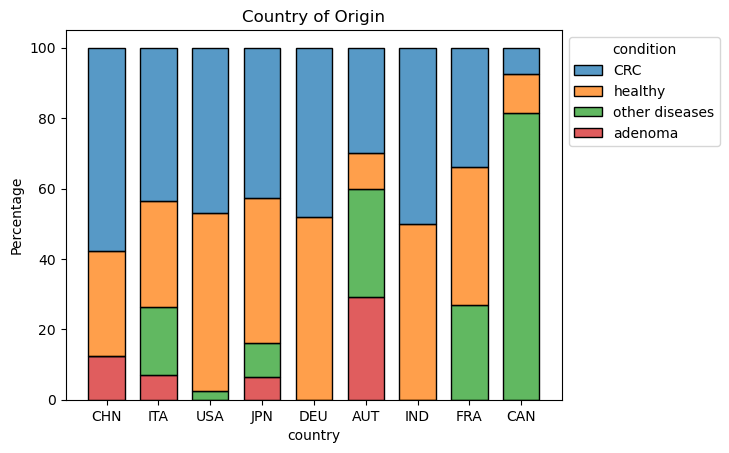

In [58]:
# same plot as above but with percentages instead of absolute values
ax = sns.histplot(stacked_df, x='country', 
             hue='condition', 
             multiple='stack',
             shrink=0.7,
             weights='percentage')

ax.set_ylabel('Percentage')
ax.set_title('Country of Origin')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1,1))

yticks = [str(int(y*100)) for y in ax.get_yticks()]
ax.set_yticklabels(yticks)

In [46]:
# value counts of all labels for the entire dataset (open in separate text editor to browse)
for column in merged_T:
    if not "field_" in column:
        print(merged_T[column].value_counts())
        print("\t")

study_name
YachidaS_2019      616
ZellerG_2014       156
FengQ_2015         154
YuJ_2015           128
WirbelJ_2018       125
VogtmannE_2016     110
HanniganGD_2017     81
ThomasAM_2018a      80
ThomasAM_2019_c     80
GuptaA_2019         60
ThomasAM_2018b      60
Name: count, dtype: int64
	
subject_id
HanniganGD_2017_A29    1
SZAXPI003409-8         1
SZAXPI003410-3         1
SZAXPI003411-6         1
SZAXPI003412-1         1
                      ..
SZAXPI003430-5         1
SZAXPI003431-1         1
SZAXPI003432-12        1
SZAXPI003433-7         1
SZAXPI003434-7         1
Name: count, Length: 1650, dtype: int64
	
body_site
stool    1650
Name: count, dtype: int64
	
antibiotics_current_use
nd    1087
no     563
Name: count, dtype: int64
	
study_condition
CRC                          701
control                      694
adenoma                      209
carcinoma_surgery_history     40
nd                             6
Name: count, dtype: int64
	
disease
CRC                                  

# Table with condensed information about the cohorts

To get a feeling of which cohorts are similar to which (especially interesting when trying to condition a cohort on another cohort).\
Compare categorical variables (like country, sequencing_platform, DNA_extraction_kit).\
Calculate basic statistics on numerical variables for the entire cohort (e.g. mean/median age, mean/median bmi, gender ratio, diseased/healthy ratio etc.) 

In [49]:
overview_df = pd.DataFrame()

In [50]:
cohorts = merged_T['study_name'].unique().tolist()
overview_df['cohort'] = cohorts

In [ ]:
# extract the categorical variables for each cohort first
categorical_columns = [
    'country',
    'sequencing_platform',
    'DNA_extraction_kit'
]

for cohort in cohorts:
    for column in categorical_columns:
        value = merged_T.loc[merged_T['study_name'] == cohort, column].unique().tolist()
        joined_value = ','.join(value)
        overview_df.loc[overview_df['cohort'] == cohort, column] = joined_value

In [53]:
# extract the numerical values and calculate specific statistics
# variables for which the mean and median should be used
mean_median = [
    'age',
    'BMI'
]

for cohort in cohorts:
    for column in mean_median:
        
        mean = merged_T.loc[(merged_T['study_name'] == cohort) & 
                            (merged_T[column] != 'nd'), column].astype(float).mean()
        median = merged_T.loc[(merged_T['study_name'] == cohort) & 
                            (merged_T[column] != 'nd'), column].astype(float).median()
        
        overview_df.loc[overview_df['cohort'] == cohort, f"{column}_mean"] = mean
        overview_df.loc[overview_df['cohort'] == cohort, f"{column}_median"] = median

In [54]:
# add gender and disease status ratios
ratio_columns = [
    'gender',
    'disease'
]

for cohort in cohorts:
    # percentage of CRC patients
    crc_count = len(merged_T[(merged_T['study_name'] == cohort) &
                             (merged_T['disease'].str.contains('CRC'))])
    cohort_len = len(merged_T[merged_T['study_name'] == cohort])

    crc_percentage = round((crc_count / cohort_len) * 100, 2)
    overview_df.loc[overview_df['cohort'] == cohort, 'CRC Percentage (%)'] = crc_percentage

In [60]:
# save overview to file
overview_df.to_csv('../../notebooks/datav3/results/cohort_overview.csv', index=False)